In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['font.sans-serif'] = ['Taipei Sans TC Beta']

import warnings, pickle, time, os, random
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from prog.model import * 

shuffle = True
random_state = random.randint(0, 1000)
limit_end = 30
top_score = 3
test_size = 0.15
random_state

426

In [2]:
input_ = {
    "model_id": "20230807120000000",
}
model_id = input_["model_id"]

In [3]:
root = r"C:\Users\tzuli\Documents\python\teco"

# 取得train位置
train_path = os.path.join(root, "data", "train")        
os.makedirs(train_path, exist_ok = True)
data_csv = os.path.join(train_path, "train_data.csv")
output_json = os.path.join(train_path, "output.json")


# 取得model位置
model_path = os.path.join(root, "data", "train", model_id)
os.makedirs(model_path, exist_ok = True)

model_detail = os.path.join(model_path, "model")
os.makedirs(model_detail, exist_ok = True)

In [4]:
df = pd.read_csv(data_csv)
print(df.shape)
df.head(3)

(278, 16)


,日期,工號,序號,平衡轉速,初始_L側角度,初始_L側不平衡量,初始_F側角度,初始_F側不平衡量,平衡_L側角度,平衡_L側配重,平衡_F側角度,平衡_F側配重,最終_L側角度,最終_L側不平衡量,最終_F側角度,最終_F側不平衡量
0,2023-06-01,FC236606T1-2,1,590,12.0,266.0,259.0,181.0,12.0,275.0,259.0,180.0,358.0,58.20,293.0,23.00
1,2023-06-01,FC236606T1-2,2,590,358.0,58.2,293.0,23.0,358.0,60.0,293.0,23.0,307.0,3.50,241.0,3.90
2,2023-06-01,FC236606T1-2,3,590,307.0,3.5,241.0,3.9,307.0,4.0,241.0,4.0,322.0,0.46,214.0,0.36


##### 刪除缺失值

<Axes: >

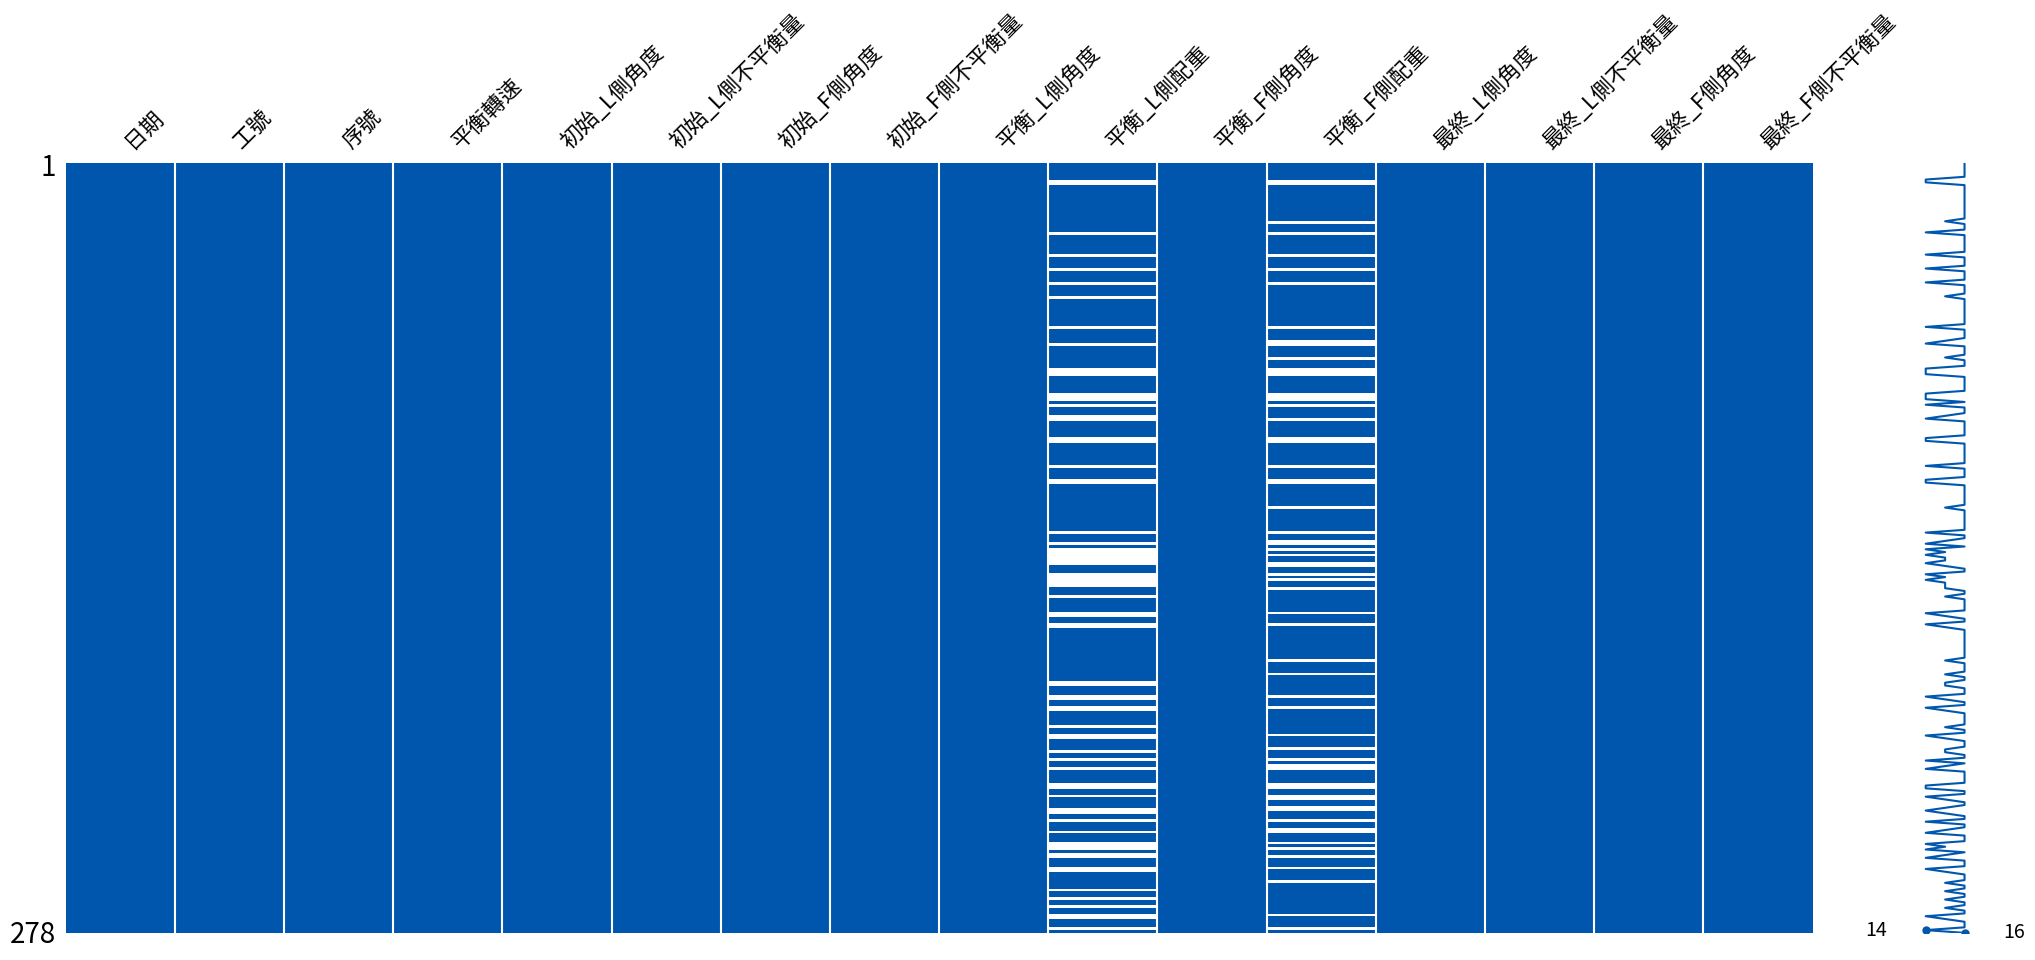

In [5]:
import missingno as msno
msno.matrix(df, color = (0, 0.34, 0.68))

<Axes: >

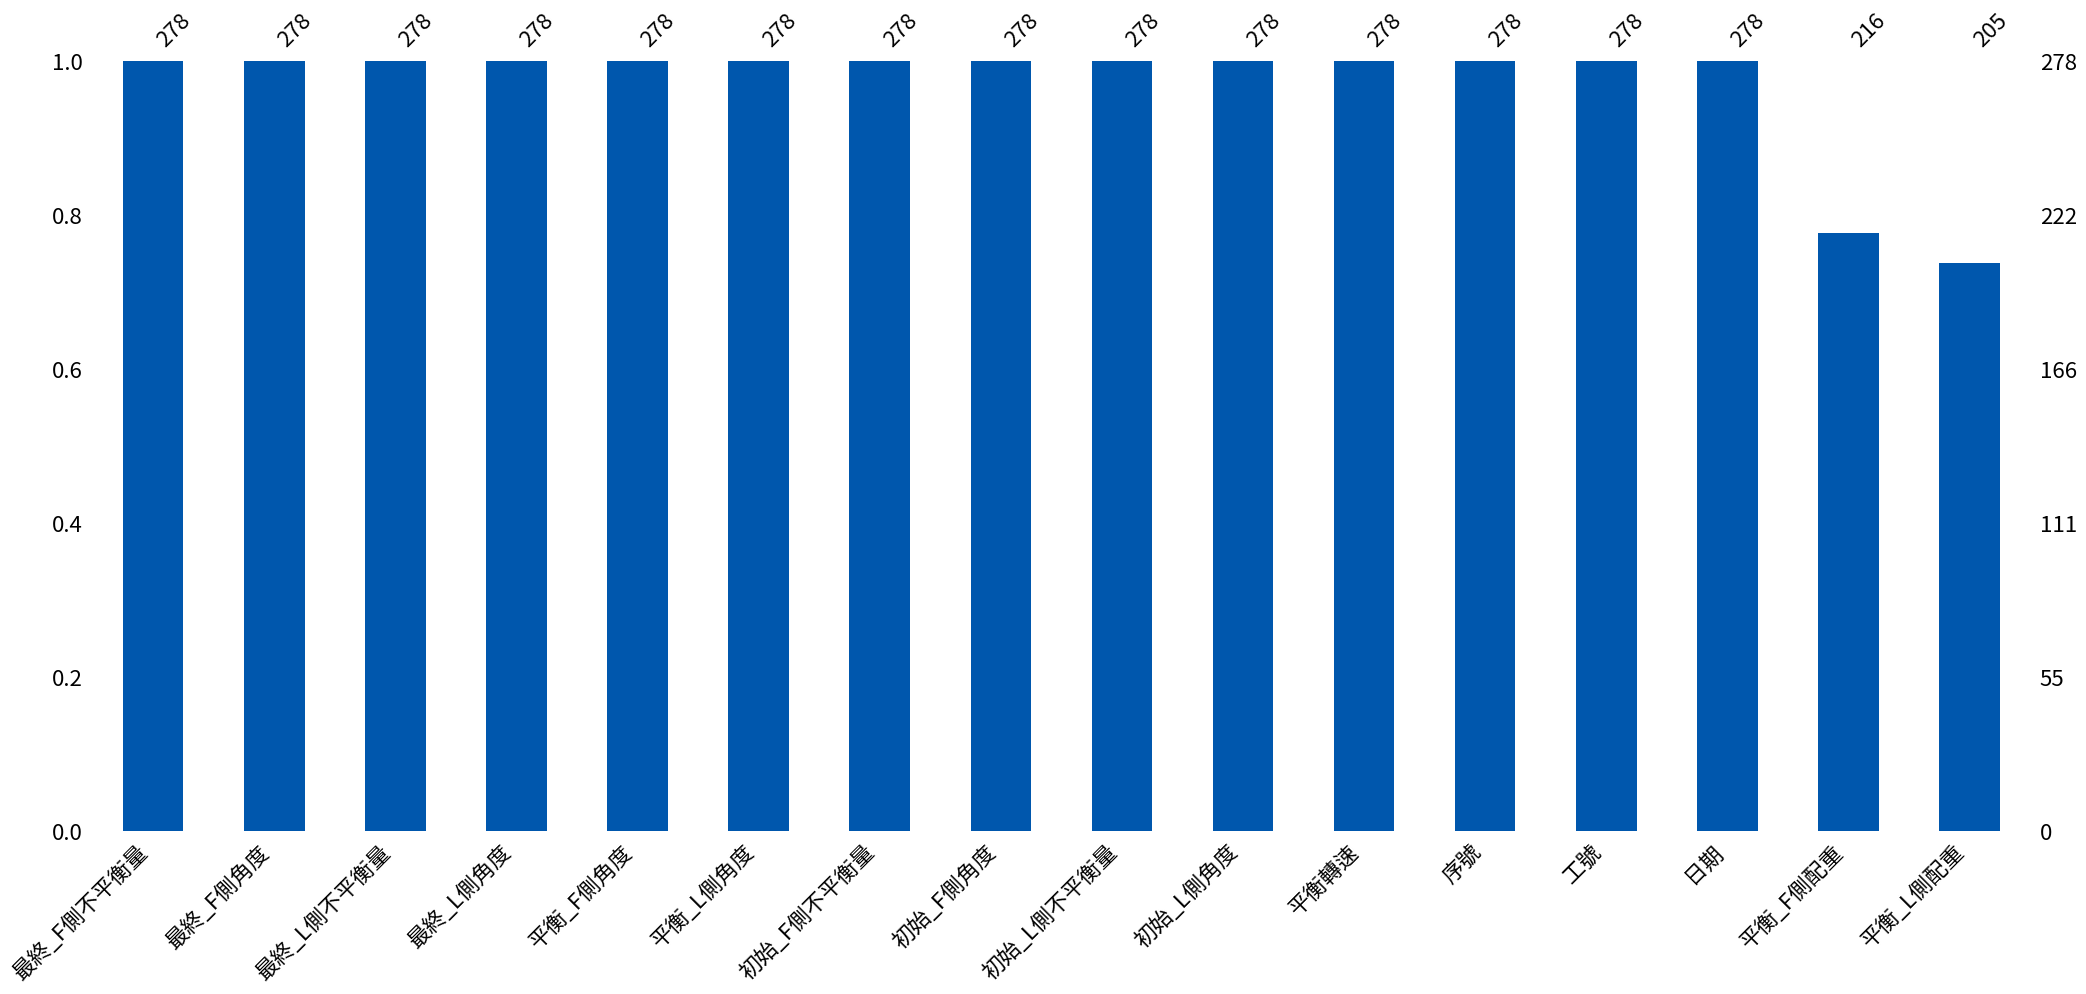

In [6]:
msno.bar(df, sort='descending', color = (0, 0.34, 0.68))

In [7]:
# df = df[~df.isnull().any(axis = 1)].reset_index(drop = True)
df = df.dropna().reset_index(drop = True)
df.shape

(190, 16)

##### 刪除特徵

In [8]:
df = df.drop(['日期', '工號', '序號'], axis = 1)
df.head(3)

,平衡轉速,初始_L側角度,初始_L側不平衡量,初始_F側角度,初始_F側不平衡量,平衡_L側角度,平衡_L側配重,平衡_F側角度,平衡_F側配重,最終_L側角度,最終_L側不平衡量,最終_F側角度,最終_F側不平衡量
0,590,12.0,266.0,259.0,181.0,12.0,275.0,259.0,180.0,358.0,58.20,293.0,23.00
1,590,358.0,58.2,293.0,23.0,358.0,60.0,293.0,23.0,307.0,3.50,241.0,3.90
2,590,307.0,3.5,241.0,3.9,307.0,4.0,241.0,4.0,322.0,0.46,214.0,0.36


#### 預期結果

In [9]:
df["預期_F側不平衡量"] = df["初始_F側不平衡量"] - df["平衡_F側配重"]
df["預期_L側不平衡量"] = df["初始_L側不平衡量"] - df["平衡_L側配重"]

df["初始_不平衡量_diff"] = abs(df["初始_L側不平衡量"] - df["初始_F側不平衡量"])
df["平衡_不平衡量_diff"] = abs(df["平衡_L側配重"] - df["平衡_F側配重"])

diff = abs(df["初始_L側角度"] - df["初始_F側角度"])
df["初始_角度_diff"] = diff.apply(lambda X: min(X, 360 - X))
diff = abs(df["平衡_L側角度"] - df["平衡_F側角度"])
df["平衡_角度_diff"] = diff.apply(lambda X: min(X, 360-X))
df.head(3)

,平衡轉速,初始_L側角度,初始_L側不平衡量,初始_F側角度,初始_F側不平衡量,平衡_L側角度,平衡_L側配重,平衡_F側角度,平衡_F側配重,最終_L側角度,最終_L側不平衡量,最終_F側角度,最終_F側不平衡量,預期_F側不平衡量,預期_L側不平衡量,初始_不平衡量_diff,平衡_不平衡量_diff,初始_角度_diff,平衡_角度_diff
0,590,12.0,266.0,259.0,181.0,12.0,275.0,259.0,180.0,358.0,58.20,293.0,23.00,1.0,-9.0,85.0,95.0,113.0,113.0
1,590,358.0,58.2,293.0,23.0,358.0,60.0,293.0,23.0,307.0,3.50,241.0,3.90,0.0,-1.8,35.2,37.0,65.0,65.0
2,590,307.0,3.5,241.0,3.9,307.0,4.0,241.0,4.0,322.0,0.46,214.0,0.36,-0.1,-0.5,0.4,0.0,66.0,66.0


##### Split

In [10]:
target_vol = ["最終_L側不平衡量", "最終_F側不平衡量"]
target_angle = ["最終_L側角度", "最終_F側角度"]
features = df.columns.drop(target_vol + target_angle).to_list()
features

['平衡轉速',
 '初始_L側角度',
 '初始_L側不平衡量',
 '初始_F側角度',
 '初始_F側不平衡量',
 '平衡_L側角度',
 '平衡_L側配重',
 '平衡_F側角度',
 '平衡_F側配重',
 '預期_F側不平衡量',
 '預期_L側不平衡量',
 '初始_不平衡量_diff',
 '平衡_不平衡量_diff',
 '初始_角度_diff',
 '平衡_角度_diff']

In [11]:
train, test = train_test_split(df, test_size = test_size, shuffle = shuffle, random_state = random_state)
train = train.reset_index(drop = True)
test = test.reset_index(drop = True)
print(train.shape, test.shape)

(161, 19) (29, 19)


##### outlier

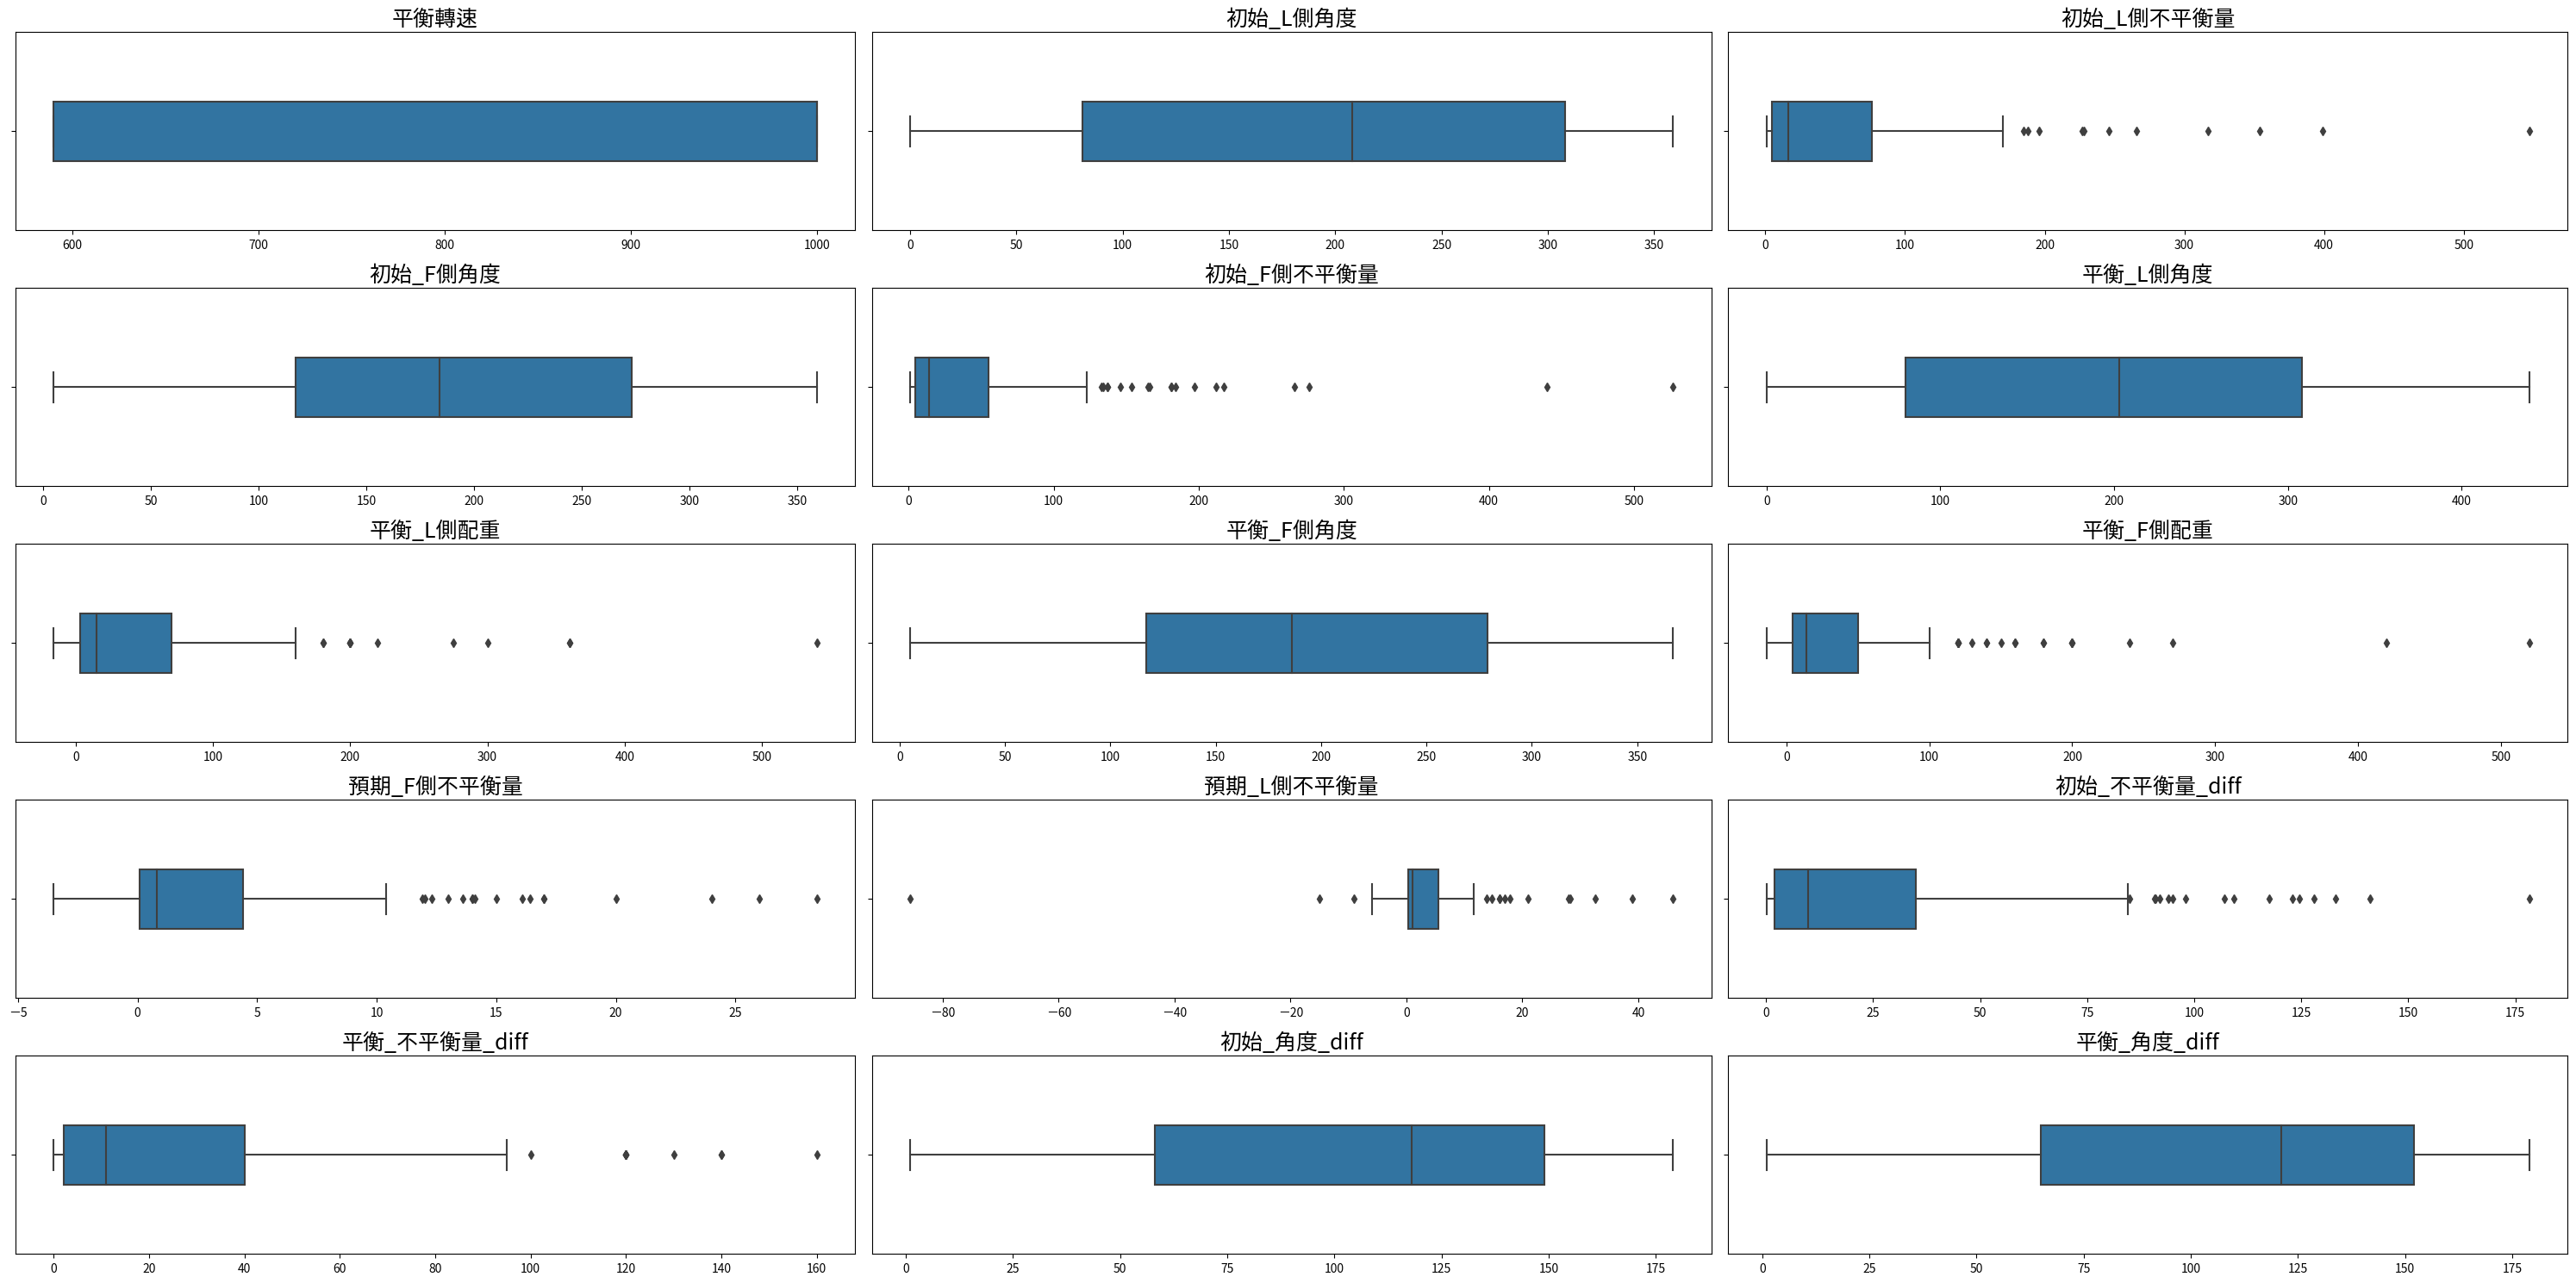

In [12]:
a, b = 5, 3
k = 0
fig, ax = plt.subplots(a, b, figsize = (30, 15))
for i in range(a):
    for j in range(b):
        sns.boxplot(x = features[k], data = train, width = 0.3, ax = ax[i, j])
        ax[i, j].set(xlabel = None, ylabel = None)#, title = features[k])
        ax[i, j].set_title(features[k], fontdict={'fontsize': 18})
        k += 1
plt.tight_layout()

In [13]:
outlier_boundary = {}
for col in features[1:]:
    Q1   = train[col].quantile(0.25)
    Q3   = train[col].quantile(0.75)
    IQR  = Q3 - Q1
    min_ = Q1 - (1.5 * IQR)
    max_ = Q3 + (1.5 * IQR)
    
    train[col] = train[col].apply(lambda X: max_ if X > max_ else X)
    train[col] = train[col].apply(lambda X: min_ if X < min_ else X)

    test[col] = test[col].apply(lambda X: max_ if X > max_ else X)
    test[col] = test[col].apply(lambda X: min_ if X < min_ else X)

    outlier_boundary[col] = {
        "min": min_,
        "max": max_,
    }

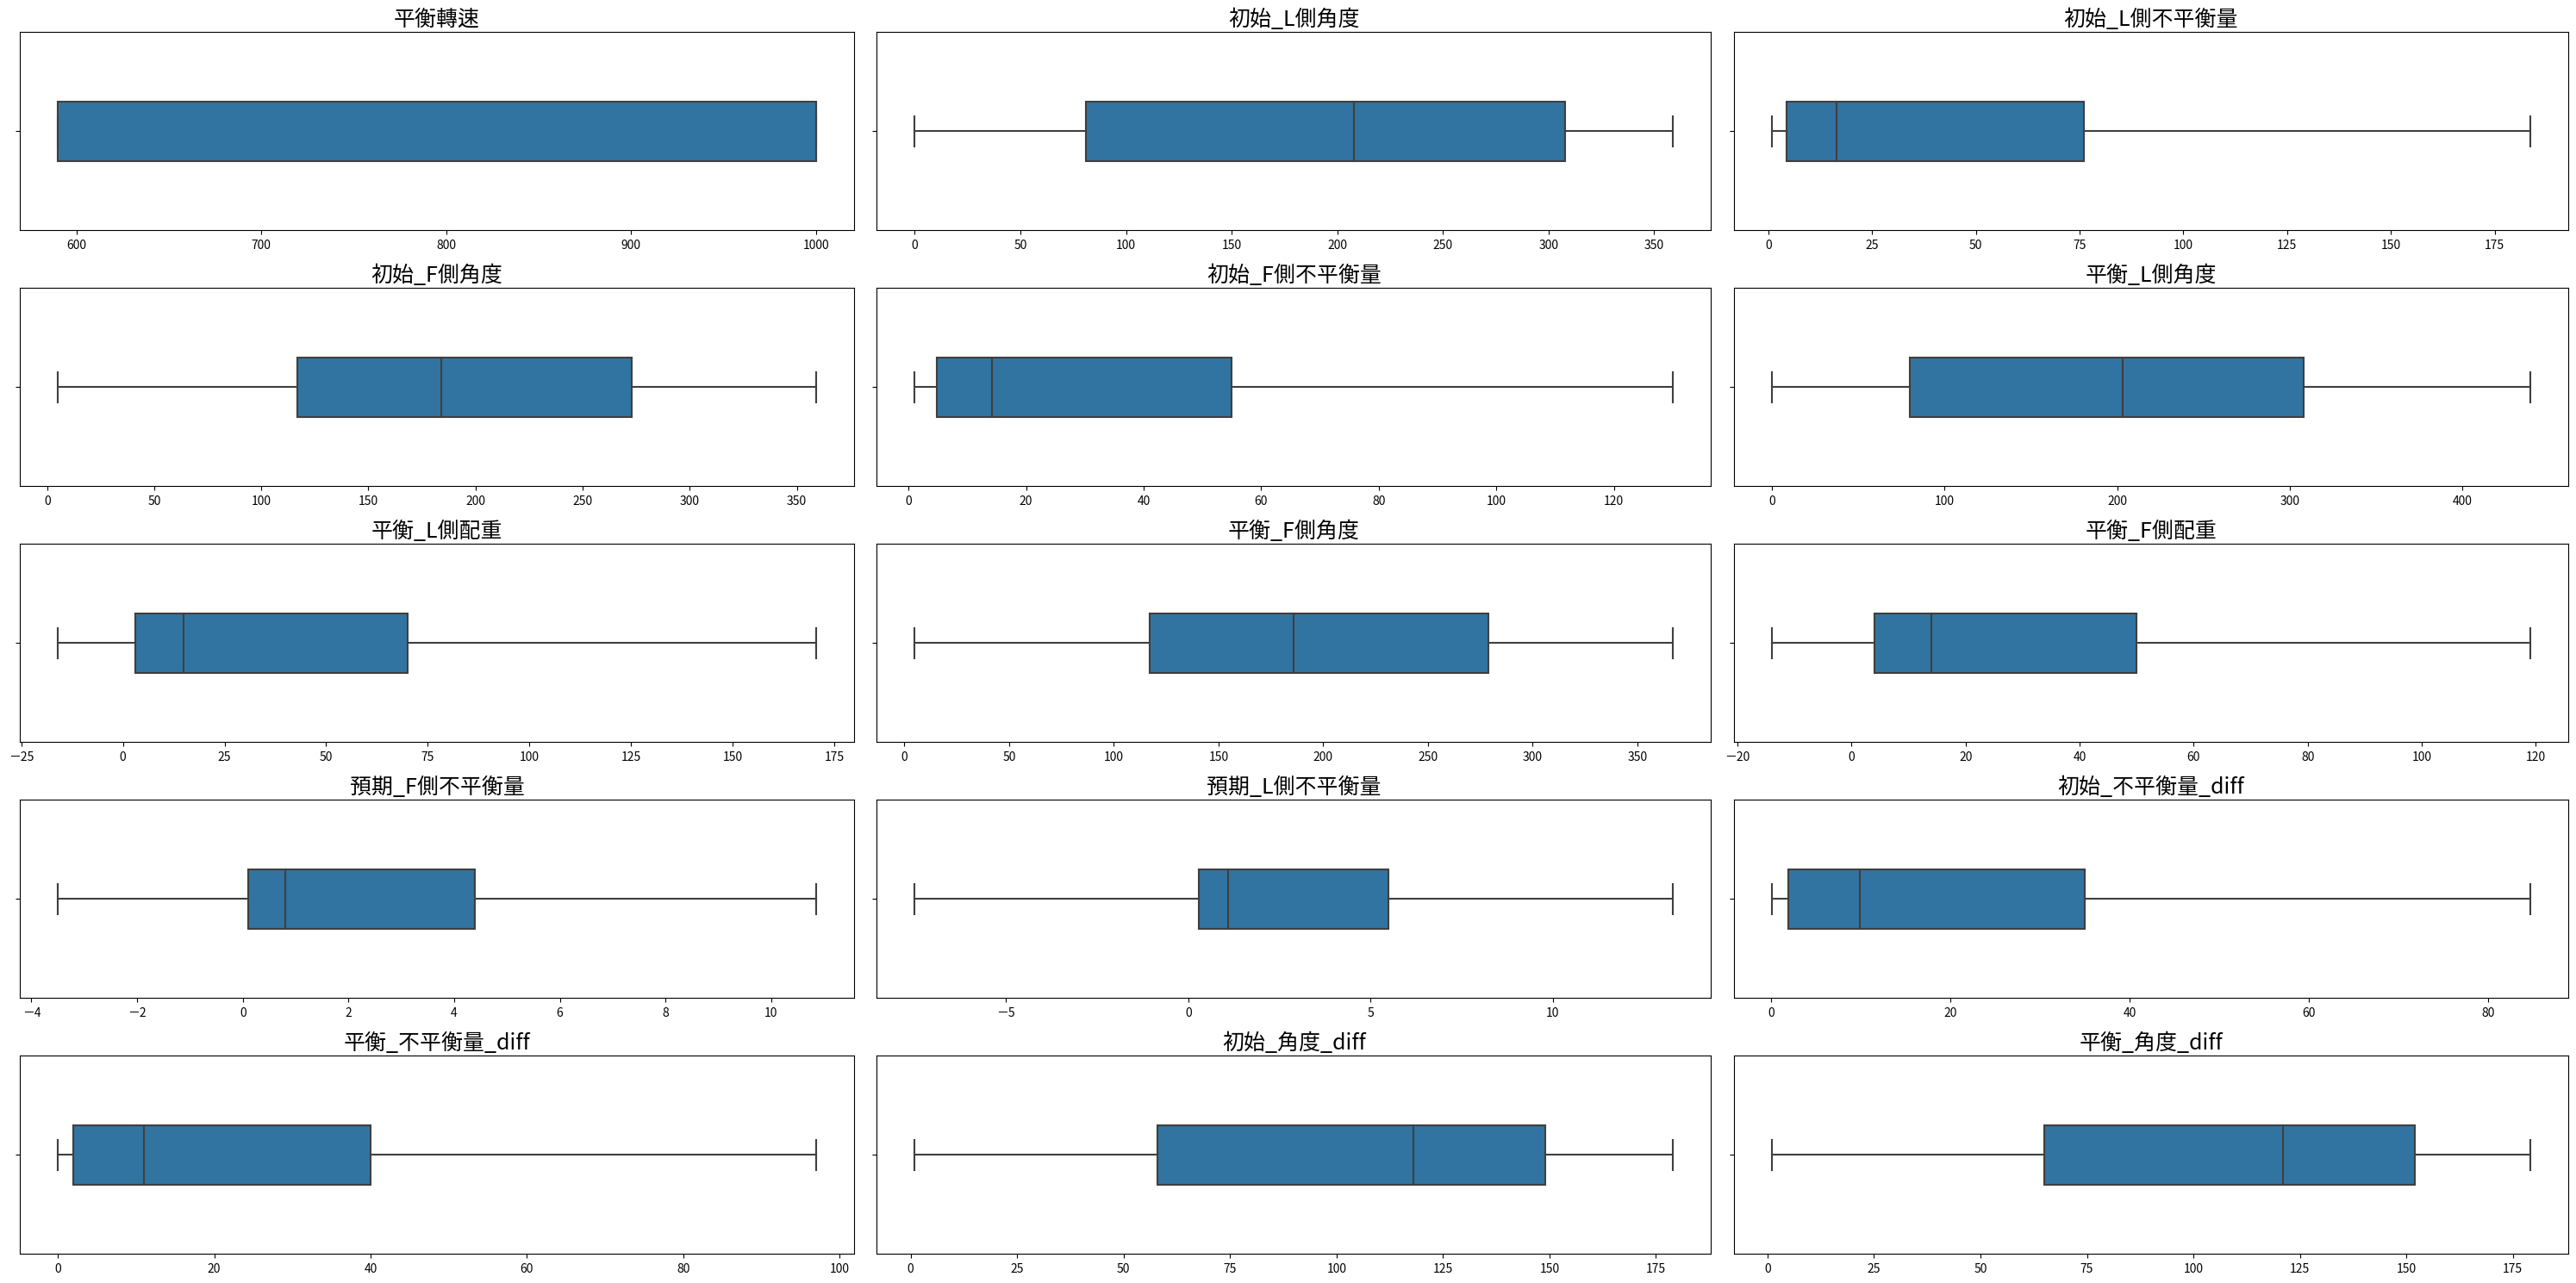

In [14]:
a, b = 5, 3
k = 0
fig, ax = plt.subplots(a, b, figsize = (30, 15))
for i in range(a):
    for j in range(b):
        sns.boxplot(x = features[k], data = train, width = 0.3, ax = ax[i, j])
        ax[i, j].set(xlabel = None, ylabel = None)#, title = features[k])
        ax[i, j].set_title(features[k], fontdict={'fontsize': 18})
        k += 1
plt.tight_layout()

##### Skew

In [15]:
from scipy.stats import skew

skewness = train[features].apply(lambda X: skew(X)).sort_values(ascending=False)
skewness = pd.DataFrame({'Feature' : skewness.index, 'Skew' : skewness.values})
skewness = skewness.query("(Skew > 0.75) | (Skew < -0.75)").reset_index(drop = True)
skew_feat = skewness["Feature"].to_list()
skew_feat

['初始_L側不平衡量',
 '平衡_不平衡量_diff',
 '初始_F側不平衡量',
 '平衡_L側配重',
 '初始_不平衡量_diff',
 '平衡_F側配重',
 '預期_F側不平衡量',
 '平衡轉速']

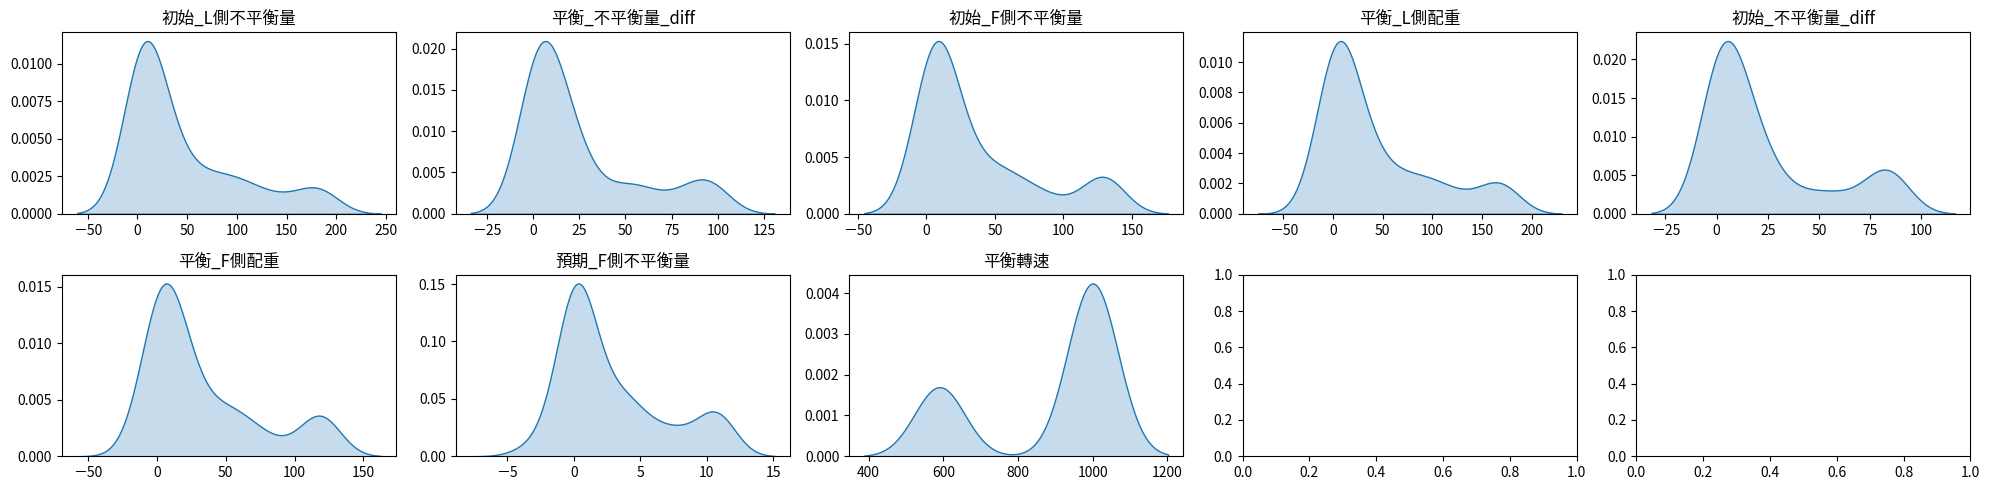

In [16]:
a, b = 2, 5
k = 0
fig, ax = plt.subplots(a, b, figsize = (20, 5))
for i in range(a):
    for j in range(b):
        sns.kdeplot(data = train, x = skew_feat[k], shade=True, ax = ax[i, j])
        ax[i, j].set(ylabel = None, xlabel = None, title = skew_feat[k])
        k += 1

        if k == len(skew_feat):
            break
fig.tight_layout()

In [17]:
from sklearn.preprocessing import PowerTransformer

pt = PowerTransformer(method = 'yeo-johnson')
train[skew_feat] = pt.fit_transform(train[skew_feat])
test[skew_feat] = pt.transform(test[skew_feat])

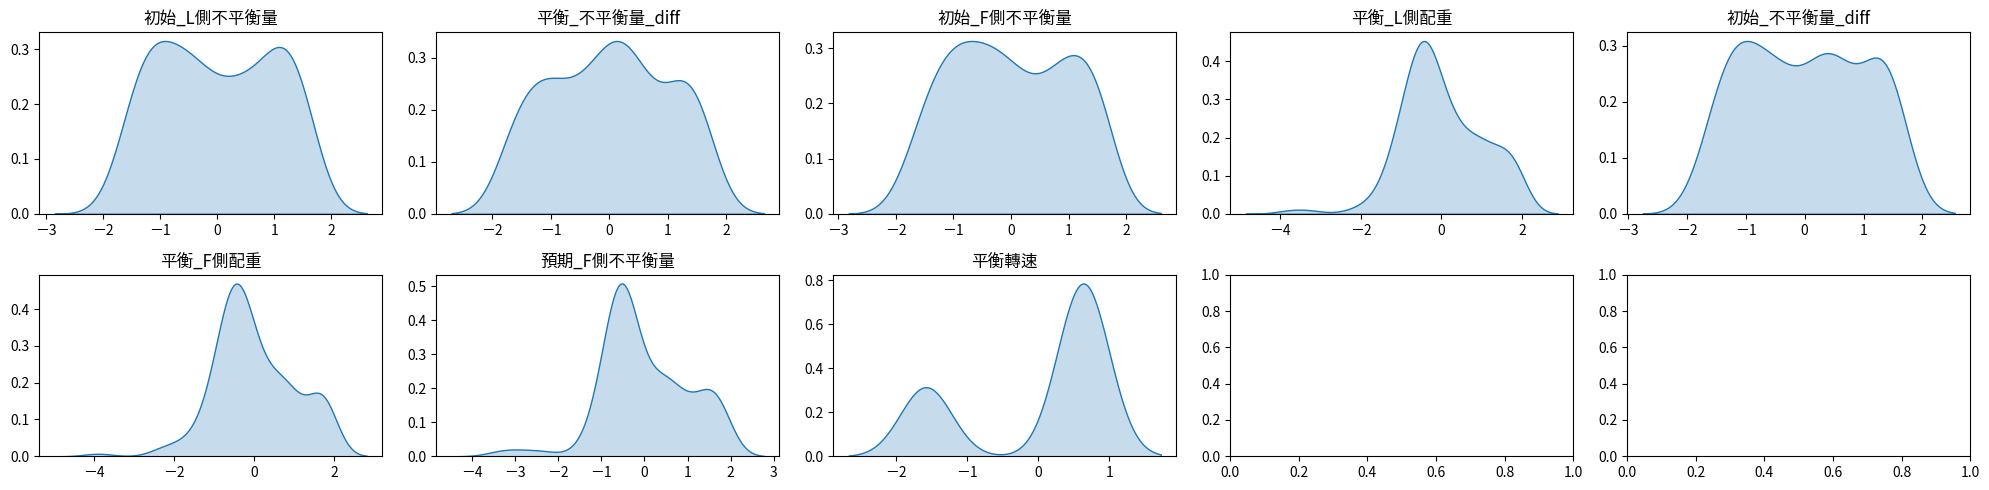

In [18]:
a, b = 2, 5
k = 0
fig, ax = plt.subplots(a, b, figsize = (20, 5))
for i in range(a):
    for j in range(b):
        sns.kdeplot(data = train, x = skew_feat[k], shade=True, ax = ax[i, j])
        ax[i, j].set(ylabel = None, xlabel = None, title = skew_feat[k])
        k += 1

        if k == len(skew_feat):
            break
fig.tight_layout()

##### Scaler

In [19]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train[features] = scaler.fit_transform(train[features])
test[features] = scaler.transform(test[features])

#### Target

a, b = 1, 2
k = 0
fig, ax = plt.subplots(a, b, figsize = (10, 3))
for j in range(b):
    sns.boxplot(data = train, x = target_vol[k], width = 0.3, ax = ax[j])
    ax[j].set(ylabel = None, xlabel = None, title = target_vol[k])
    k += 1

a, b = 1, 2
k = 0
fig, ax = plt.subplots(a, b, figsize = (10, 3))
for j in range(b):
    sns.kdeplot(data = train, x = target_vol[k], shade=True, ax = ax[j])
    ax[j].set(ylabel = None, xlabel = None, title = target_vol[k])
    k += 1

train[target_vol].describe().round(2)

#### heapmap

col_order = ['最終_L側不平衡量',  '最終_F側不平衡量', '平衡轉速', 
             '初始_L側角度', '初始_L側不平衡量', '初始_F側角度', '初始_F側不平衡量', 
             '平衡_L側角度', '平衡_L側配重', '平衡_F側角度', '平衡_F側配重', 
             '預期_F側不平衡量', '預期_L側不平衡量', '初始_不平衡量_diff', '平衡_不平衡量_diff', '初始_角度_diff', '平衡_角度_diff']

plt.figure(figsize=(20, 8))
corr = train[col_order].corr("spearman").round(2)
sns.heatmap(data = corr, annot=True, cmap = 'RdBu')
plt.xticks(rotation = 45)
plt.show()

### Model

#### L測預測

In [20]:
l_train = train[train[target_vol[0]] <= limit_end].reset_index(drop = True)
l_test = test[test[target_vol[0]] <= limit_end].reset_index(drop = True)
print(f"{len(df)} -> {len(l_train) + len(l_test)}")

190 -> 175


In [21]:
X_train = l_train[features]
X_test = l_test[features]
y_train = l_train[target_vol[0]]
y_test = l_test[target_vol[0]]
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(149, 15) (26, 15) (149,) (26,)


In [22]:
models_l = modeling(X_train, y_train, random_state)

Linear trained.
Linear (L2) trained.
Linear (L1) trained.
Neural Network trained.


In [23]:
scores0, pred_trains, pred_tests = calculate_score(models_l, X_train, X_test, y_train, y_test, scoring = "r2", cv_flag = 1, cv_scoring = "r2", random_state = random_state)
scores = scores0.sort_values(("r2", "test"), ascending = False).iloc[:top_score+1]
print("L側平衡模型:")
scores

L側平衡模型:


mse         rmse        mape          r2            
                train   test train  test train  test train  test    cv
Neural Network   9.52   4.43  3.09  2.10  0.85  0.69  0.79  0.89  0.71
Linear          10.80   6.05  3.29  2.46  1.25  1.01  0.76  0.85  0.80
Linear (L2)     10.80   6.09  3.29  2.47  1.25  1.01  0.76  0.85  0.80
Linear (L1)     14.81  11.80  3.85  3.44  1.41  0.85  0.68  0.70  0.76

In [24]:
model_l = models_l[scores.index[0]]

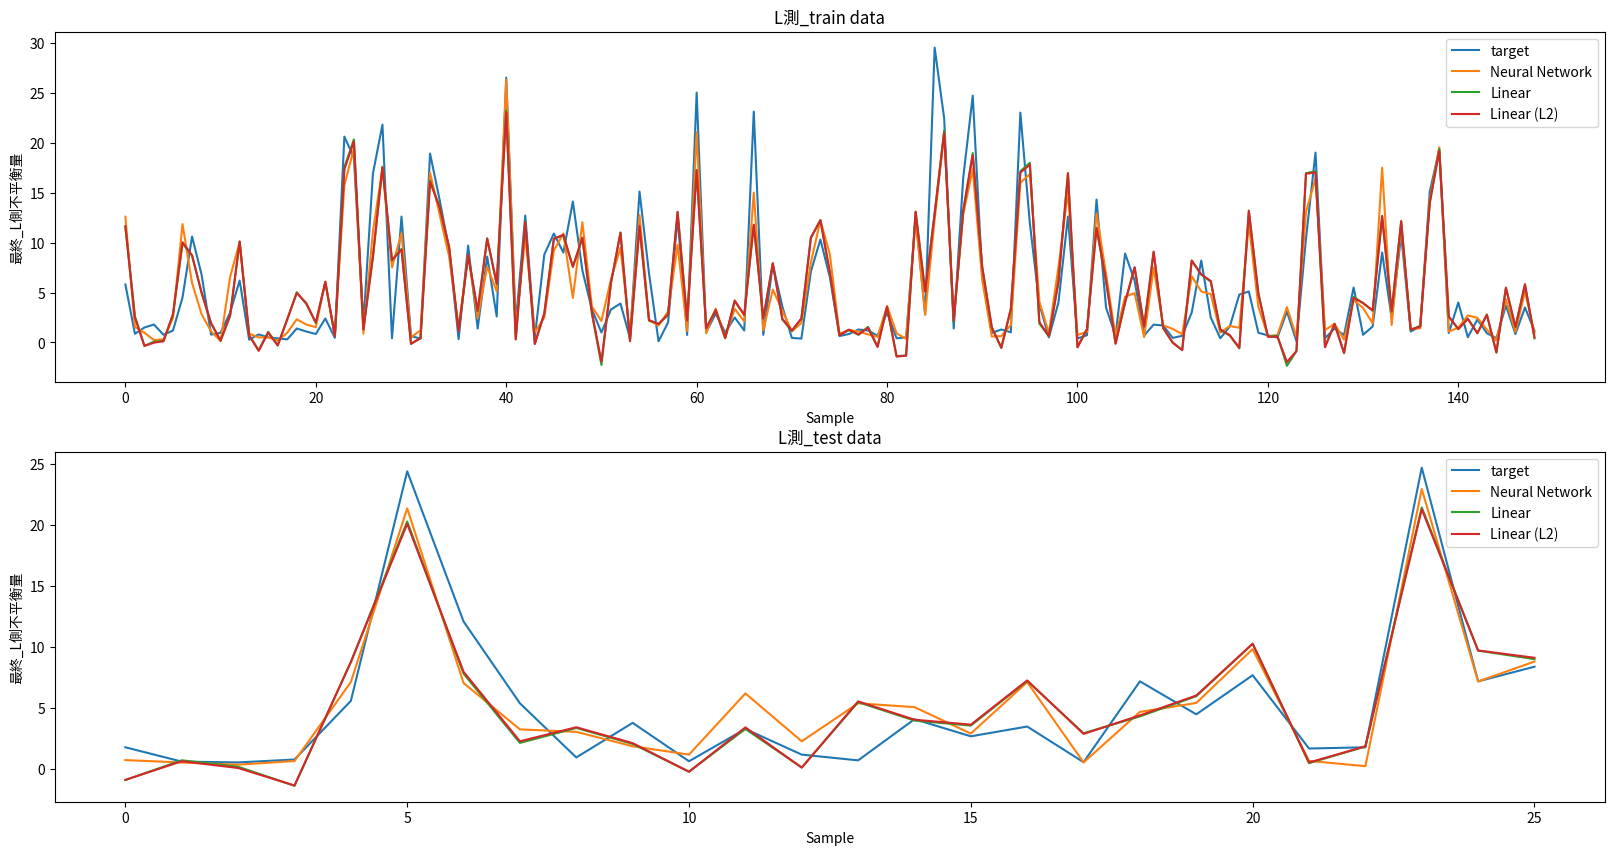

In [25]:
pred_trains_top = pred_trains[["target"] + scores.index[:top_score].to_list()]
pred_tests_top = pred_tests[["target"] + scores.index[:top_score].to_list()]

data = [pred_trains_top, pred_tests_top]
titles = ["L測_train data", "L測_test data"]
fig, ax = plt.subplots(2, 1, figsize = (20, 10))
for i in range(2):
    ax[i].plot(data[i], alpha = 1)
    # ax[i].plot(data[i]["true"], color = "#1f77b4")
    ax[i].set(ylabel = target_vol[0], xlabel = "Sample", title = titles[i])
    ax[i].legend(data[i].columns, fontsize = 10)

#### F測預測

In [26]:
f_train = train[train[target_vol[1]] <= limit_end].reset_index(drop = True)
f_test = test[test[target_vol[1]] <= limit_end].reset_index(drop = True)
print(f"{len(df)} -> {len(f_train) + len(f_test)}")

190 -> 176


In [27]:
X_train = f_train[features]
X_test = f_test[features]
y_train = f_train[target_vol[1]]
y_test = f_test[target_vol[1]]
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(149, 15) (27, 15) (149,) (27,)


In [28]:
models_f = modeling(X_train, y_train, random_state = random_state)

Linear trained.
Linear (L2) trained.
Linear (L1) trained.
Neural Network trained.


In [29]:
scores0, pred_trains, pred_tests = calculate_score(models_f, X_train, X_test, y_train, y_test, scoring = "r2", cv_flag = 1, cv_scoring = "r2", random_state = random_state)
scores = scores0.sort_values(("r2", "test"), ascending = False).iloc[:top_score+1]
print("F側平衡模型:")
scores

F側平衡模型:


mse         rmse        mape          r2            
                train   test train  test train  test train  test    cv
Linear          12.82  16.90  3.58  4.11  1.38  0.83  0.67  0.68 -0.17
Linear (L2)     12.83  17.01  3.58  4.12  1.37  0.83  0.67  0.68 -0.13
Neural Network  10.19  16.80  3.19  4.10  0.80  0.80  0.74  0.68  0.57
Linear (L1)     16.37  27.01  4.05  5.20  1.49  0.96  0.58  0.49  0.03

In [30]:
model_f = models_f[scores.index[0]]

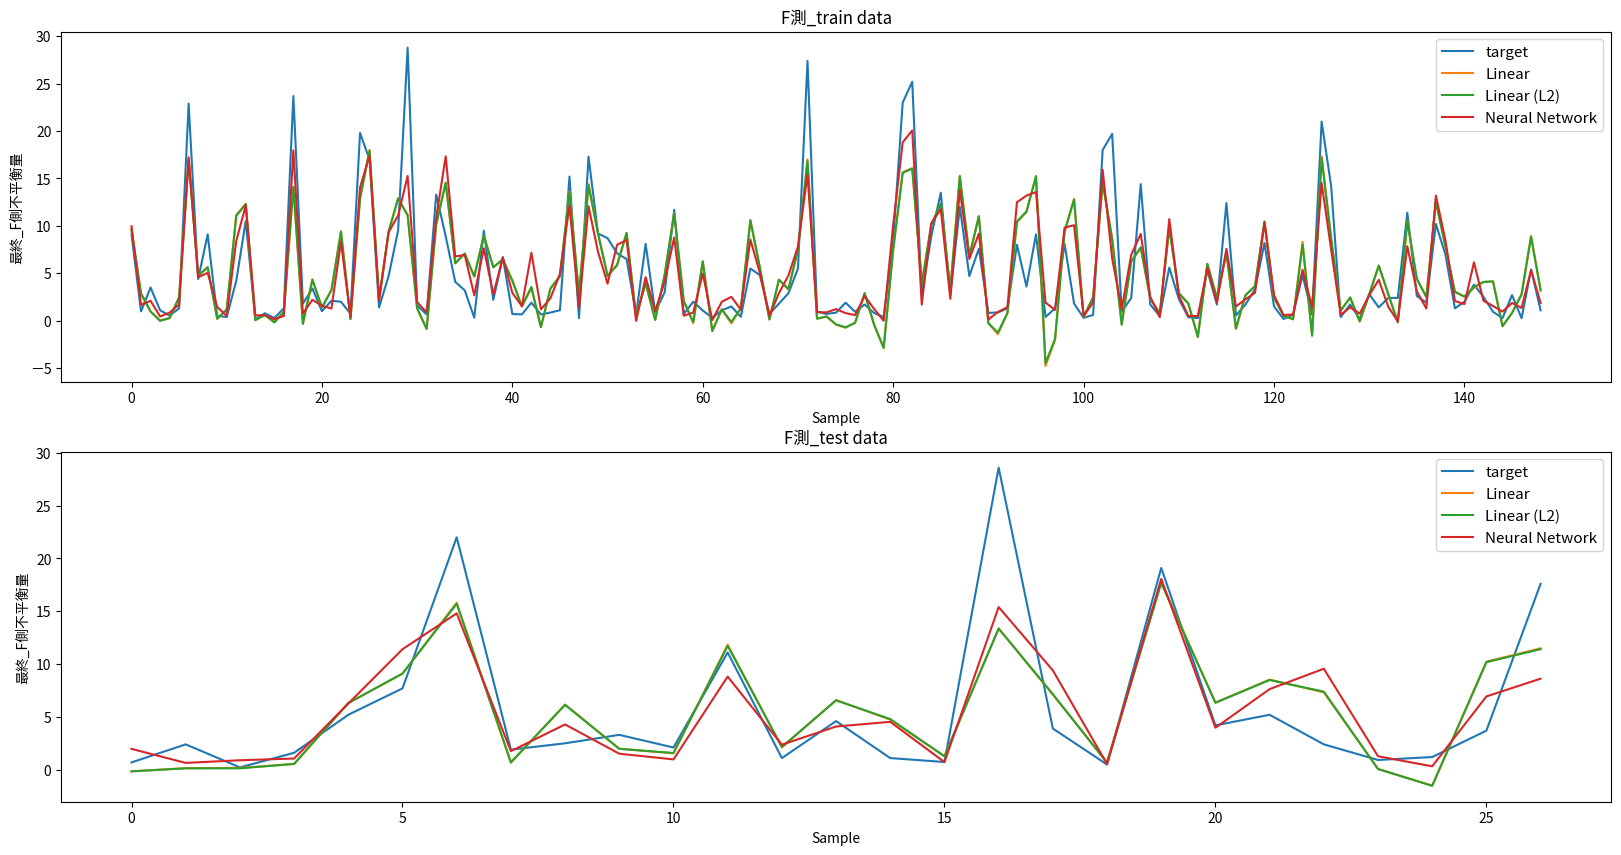

In [31]:
pred_trains_top = pred_trains[["target"] + scores.index[:top_score].to_list()]
pred_tests_top = pred_tests[["target"] + scores.index[:top_score].to_list()]

data = [pred_trains_top, pred_tests_top]
titles = ["F測_train data", "F測_test data"]
fig, ax = plt.subplots(2, 1, figsize = (20, 10))
for i in range(2):
    ax[i].plot(data[i], alpha = 1)
    # ax[i].plot(data[i]["true"], color = "#1f77b4")
    ax[i].set(ylabel = target_vol[1], xlabel = "Sample", title = titles[i])
    ax[i].legend(data[i].columns, fontsize = 11)

#### Save

In [32]:
pickle.dump(features, open(os.path.join(model_detail, "feat_order.pkl"), "wb"))
pickle.dump(outlier_boundary, open(os.path.join(model_detail, "outlier_boundary.pkl"), "wb"))
pickle.dump(skew_feat, open(os.path.join(model_detail, "skew_feat.pkl"), "wb"))
pickle.dump(pt, open(os.path.join(model_detail, "power_tf.pkl"), "wb"))
pickle.dump(scaler, open(os.path.join(model_detail, "scaler.pkl"), "wb"))
pickle.dump(model_l, open(os.path.join(model_detail, "model_l.pkl"), "wb"))
pickle.dump(model_f, open(os.path.join(model_detail, "model_f.pkl"), "wb"))